In [1]:
import os
import glob

import skimage
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import scipy
from skimage import transform as sktr
from skimage.measure import regionprops
import os
import h5py
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="7"

import albumentations as Alb
import torch
import torchvision.models as tmodels
from cv2 import BORDER_CONSTANT, BORDER_REPLICATE, BORDER_REFLECT
import torch.nn as nn
import torch.nn.functional as F
#import torchvision.transforms as ttransforms
import torch
import torchvision.models as tmodels
import torch.utils.data as tdata
from skimage.io import imread
import random
import logging
import pandas as pd


from model import construct_model
from helpers import *
from model_main_ops import get_cv
from model_main_ops.datareader import DataReader, train_aug_ops, constant_ops
from model_main_ops.performance_metric import ScoreRecorder, compute_metric
from skimage.transform import resize

In [2]:
#to_plot = set(['P22', 'P24', 'P25', 'P3', 'P31', 'P23', 'WCH_P5', 'P70', 'P54', 'P56', 'P55', 'N18', 'N26', 'WCH_P18'])

[0.] 0.17918757


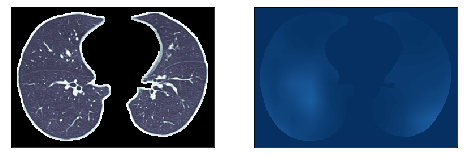

[0.] 0.7298351


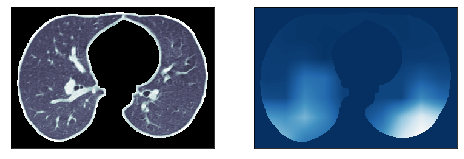

[0.] 0.04456787


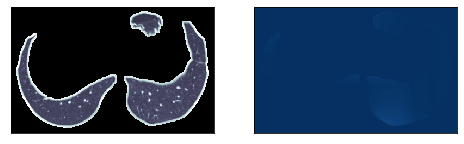

[0.] 0.024101704


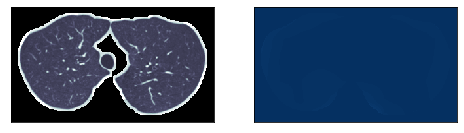

[0.] 0.5100492


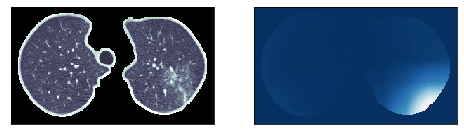

[0.] 0.055346325


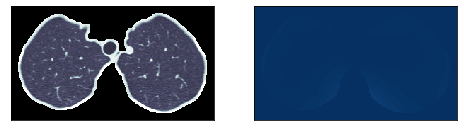

[0.] 0.033298537


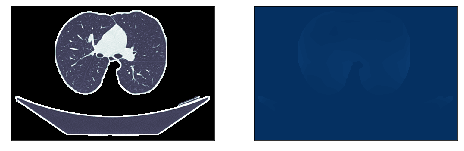

[0.] 0.7646849


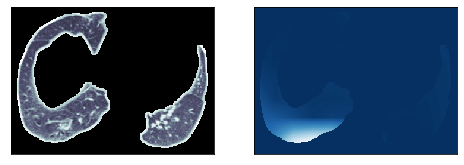

[0.] 0.02448655


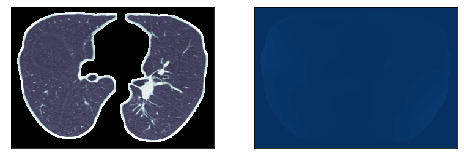

[0.] 0.97469133


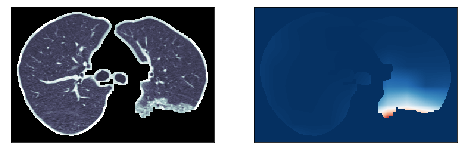

[0.] 0.08496852


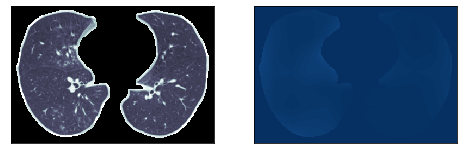

[0.] 0.48882058


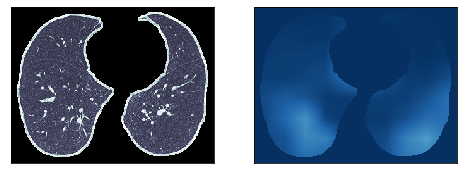

[0.] 0.07105068


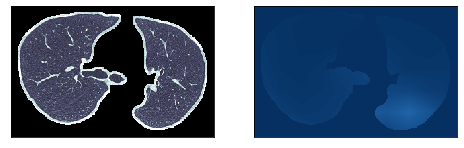

[0.] 0.7694385


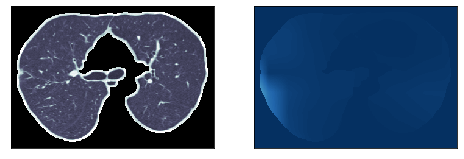

[0.] 0.2919947


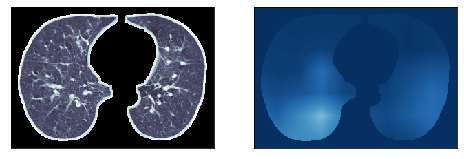

[0.] 0.73565376


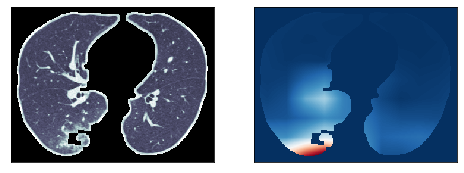

[0.] 0.5930883


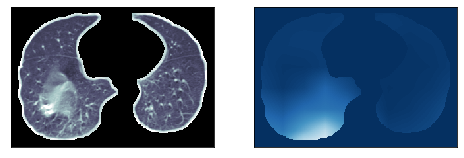

[0.] 0.5102031


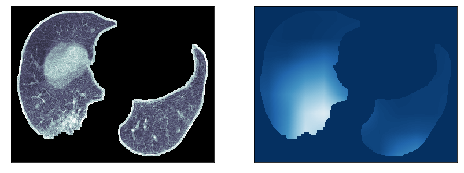

[0.] 0.021173527


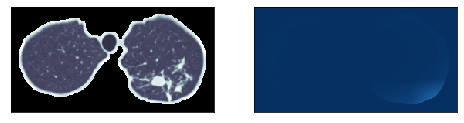

[1.] 0.86242867


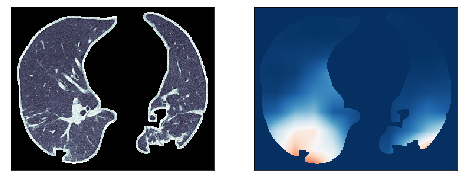

[1.] 0.9909456


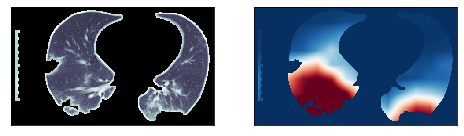

[1.] 0.96274686


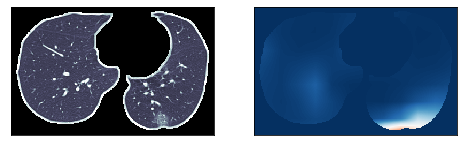

[1.] 0.9232976


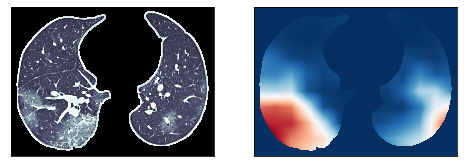

[1.] 0.8320231


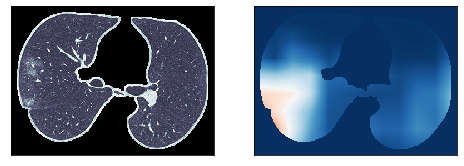

[1.] 0.98613435


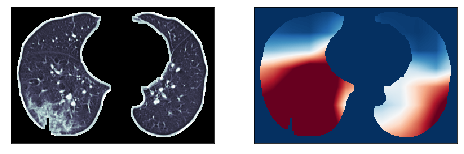

[1.] 0.09222728


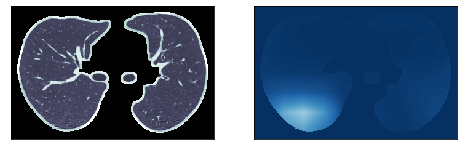

[1.] 0.9779546


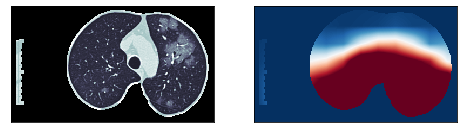

[1.] 0.021050146


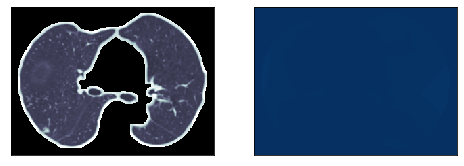

[1.] 0.3609708


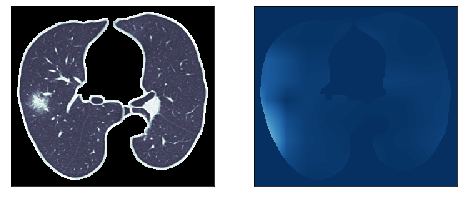

[1.] 0.79070395


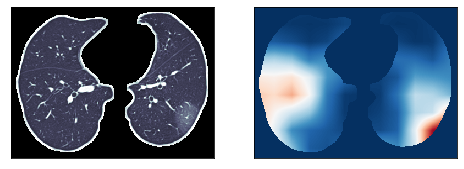

[1.] 0.96045375


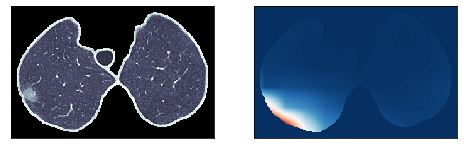

[1.] 0.8220869


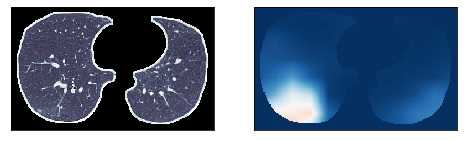

[1.] 0.038614232


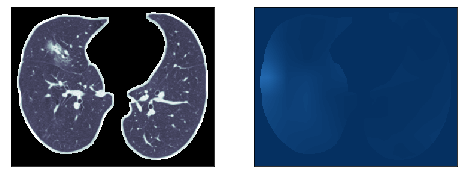

[1.] 0.93078244


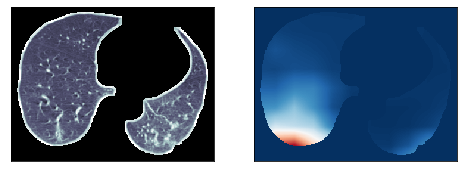

[1.] 0.25260258


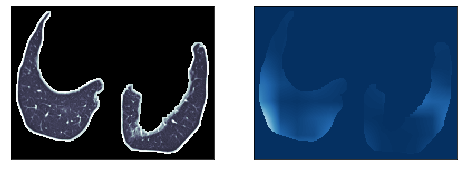

[1.] 0.9916592


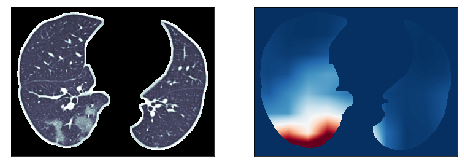

[1.] 0.916378


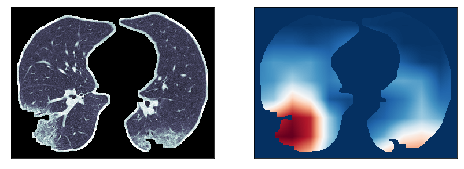

[1.] 0.659063


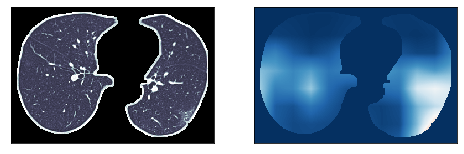

[1.] 0.6327103


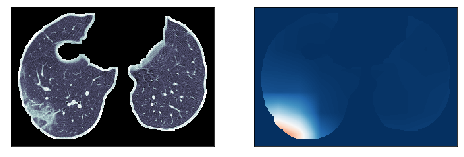

[1.] 0.94485074


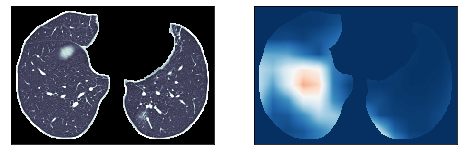

[1.] 0.1314958


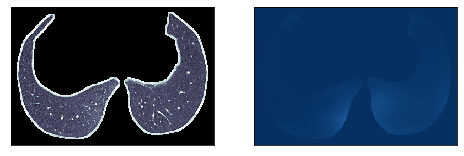

[1.] 0.9176703


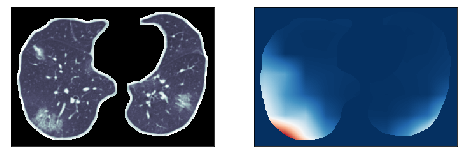

[1.] 0.9297529


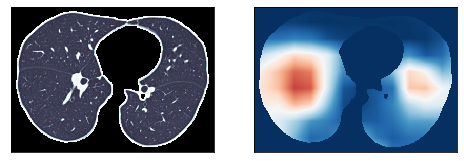

[1.] 0.9680618


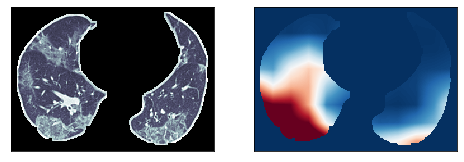

[1.] 0.53957987


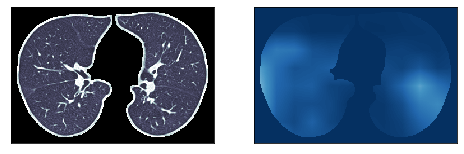

[1.] 0.90809536


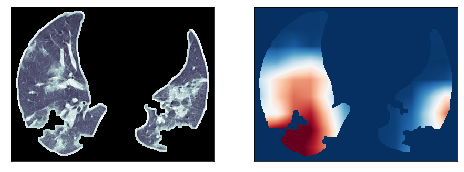

[1.] 0.82727814


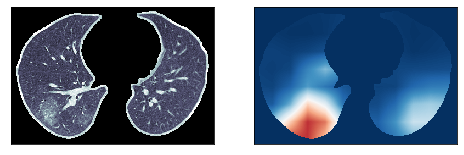

[1.] 0.8154247


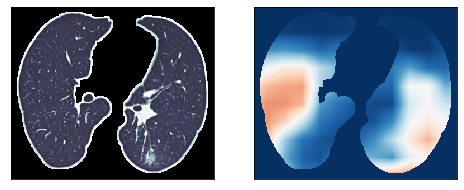

[1.] 0.6224142


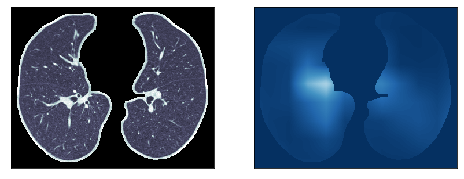

[1.] 0.37791017


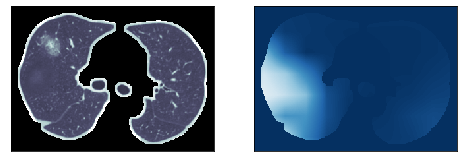

[1.] 0.75913537


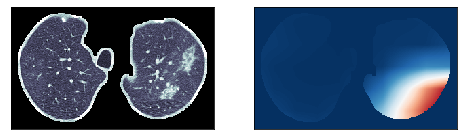

[1.] 0.78501195


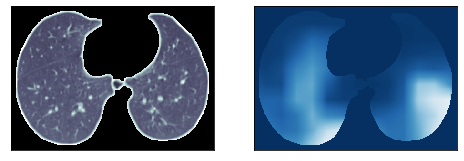

[1.] 0.1957799


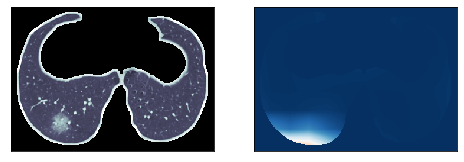

[1.] 0.62550086


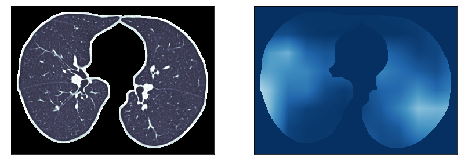

[1.] 0.7094457


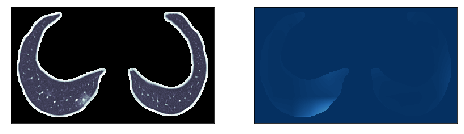

[1.] 0.90462196


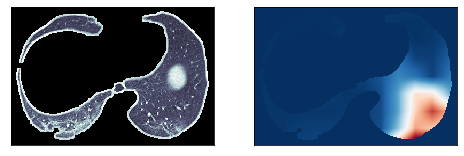

[1.] 0.9304242


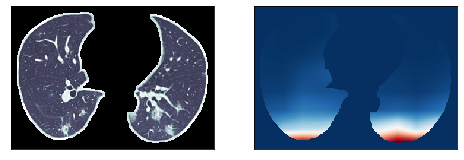

[1.] 0.9441249


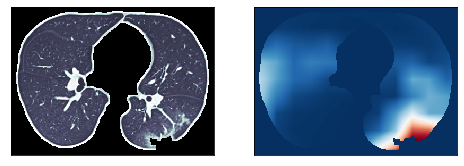

[1.] 0.930335


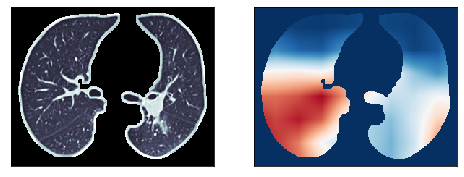

[1.] 0.95426536


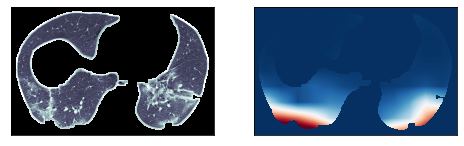

[1.] 0.8802884


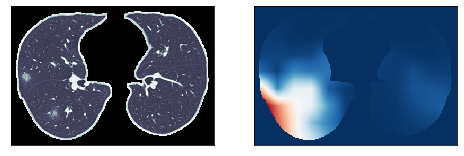

[1.] 0.8900581


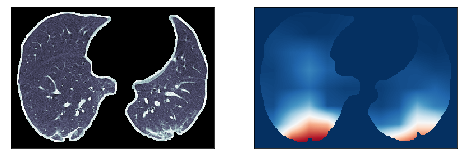

[1.] 0.7895802


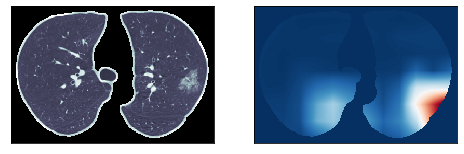

[1.] 0.7951563


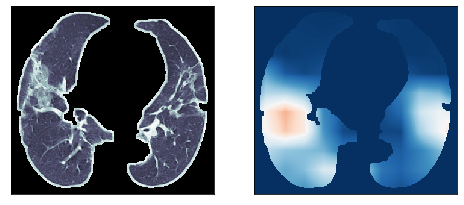

[1.] 0.8229121


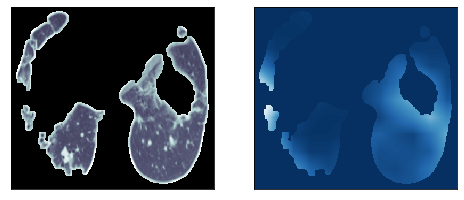

[1.] 0.9121317


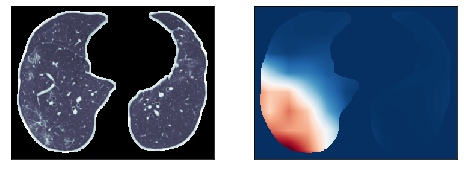

[1.] 0.9534571


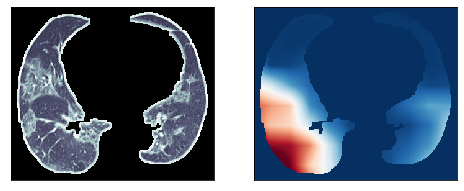

[1.] 0.6330272


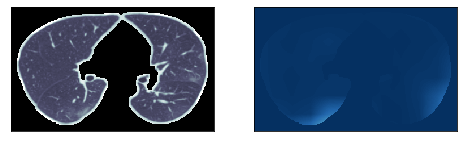

[0.] 0.5456409


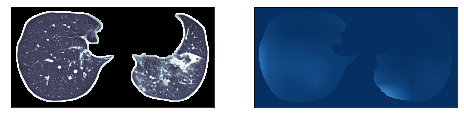

[0.] 0.7683367


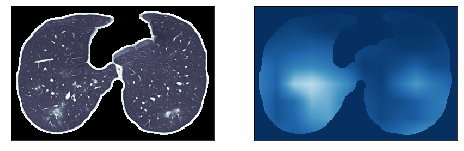

[0.] 0.8415415


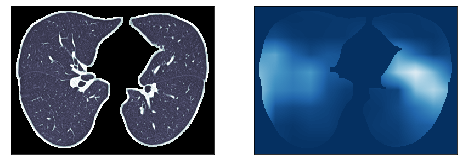

[0.] 0.5246839


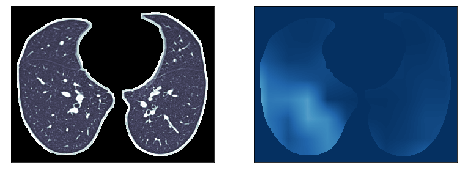

[0.] 0.3391283


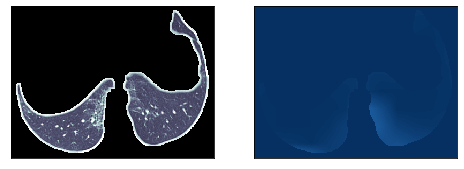

[0.] 0.5762282


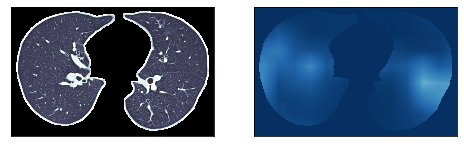

[0.] 0.5107788


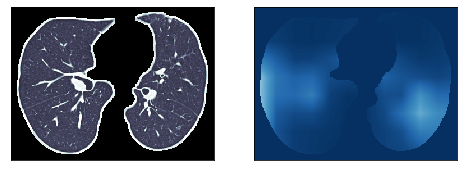

[0.] 0.6418095


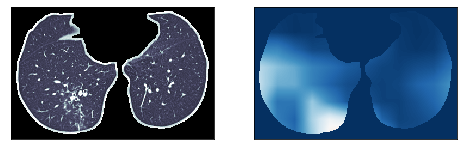

[0.] 0.060062833


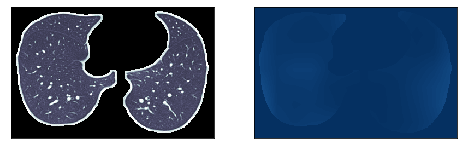

[0.] 0.18277271


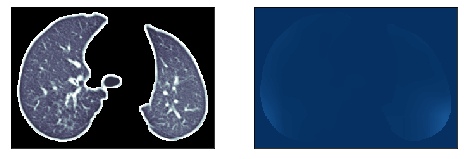

[0.] 0.64153755


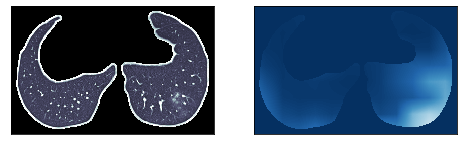

[0.] 0.2672884


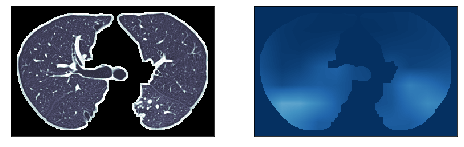

[0.] 0.06477365


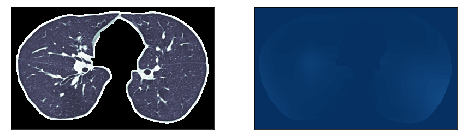

[0.] 0.101978555


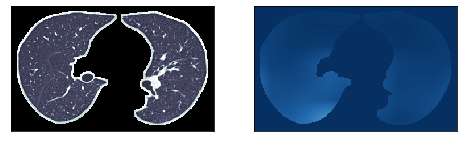

[0.] 0.06326067


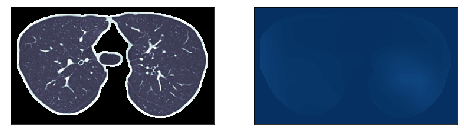

[0.] 0.33353123


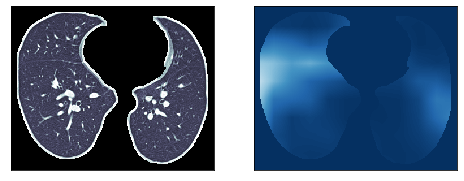

[0.] 0.048032407


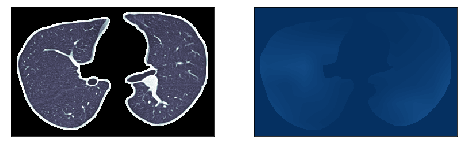

[0.] 0.21273299


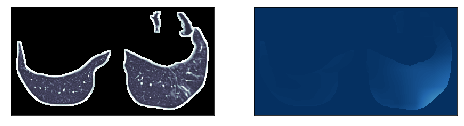

[0.] 0.32157516


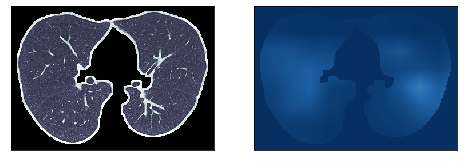

[0.] 0.05509493


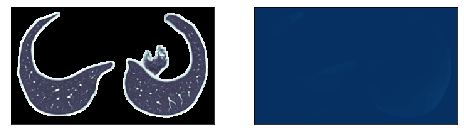

[0.] 0.17053372


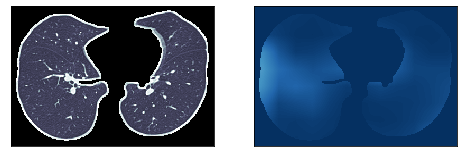

[0.] 0.44782943


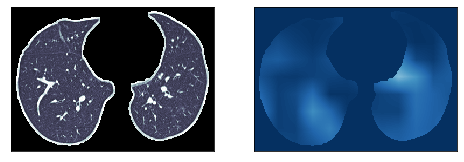

[0.] 0.07184332


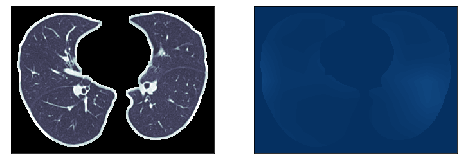

[0.] 0.8566045


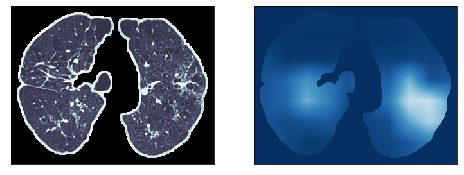

[1.] 0.91825277


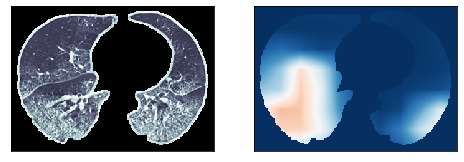

[1.] 0.49867308


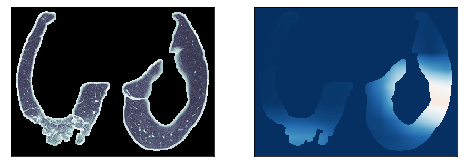

[0.] 0.8227849


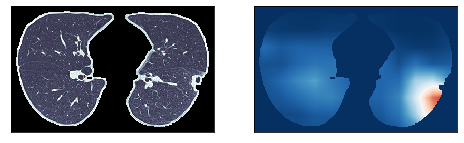

[0.] 0.02739451


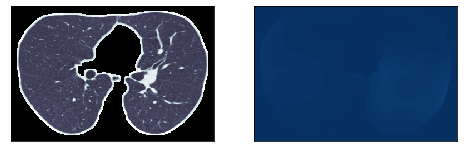

[0.] 0.035066396


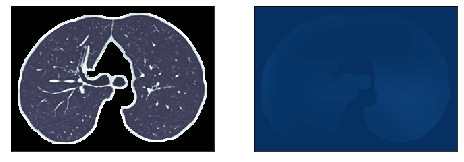

[0.] 0.12083465


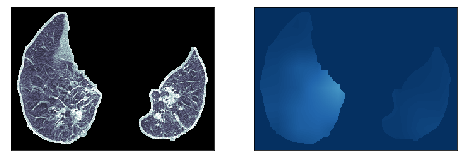

[0.] 0.43481025


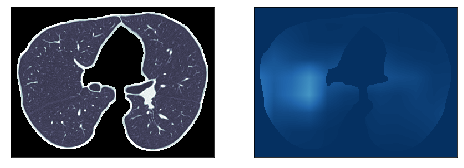

[0.] 0.020886498


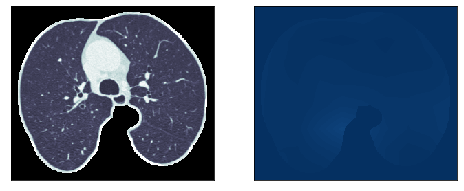

In [6]:
model = construct_model()
model.cuda()
model_to_use = 'model_best.pth'

test_info = get_cv.get_test_split()
test_datareader = DataReader(test_info, transform=constant_ops)
test_generator = tdata.DataLoader(test_datareader, batch_size=1, shuffle=False, pin_memory = True)



for i in range(0, 3000, 30):
    x, y = test_datareader[i]
    img_to_plot = np.squeeze(x)
    
    for cv_fold in range(5):
        model.load_state_dict(torch.load(os.path.join('model_cv%d' % cv_fold, model_to_use) ))
        model.eval()
        
        xt = torch.from_numpy(x[np.newaxis]).cuda()
        prob = torch.sigmoid(model(xt, is_pooling = False))
        prob = prob.detach().cpu().numpy()
        prob_max = prob.max()
        
        if cv_fold == 0:
            heatmap_to_plot = resize(np.squeeze(prob), (512, 512)) * (np.squeeze(x) > 0.5 )
        else:
            heatmap_to_plot += resize(np.squeeze(prob), (512, 512)) * (np.squeeze(x) > 0.5 )           
    
    heatmap_to_plot /= 5.
    
    i0, j0, i1, j1 = regionprops((img_to_plot > 0.5).astype('int'))[0].bbox
    i0, j0 = max(i0 - 10, 0), max(j0 - 10, 0)
    i1, j1 = i1 + 10, j1 + 10
    img_to_plot = img_to_plot[i0:i1, j0:j1]
    heatmap_to_plot = heatmap_to_plot[i0:i1, j0:j1]
    
    print(y, prob_max)
    fig, axes = plt.subplots(1, 2, figsize = (8, 4))
    ax = axes[0]
    ax.imshow(img_to_plot, cmap = 'bone')
    ax.set_xticks([])
    ax.set_yticks([])
    ax = axes[1]
    ax.imshow(heatmap_to_plot, cmap = 'RdBu_r', vmax = 0.5, vmin = 0.)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.savefig(fn, transparent = True)
    plt.show()
        

In [ ]:
plt.imshow(heatmap_to_plot, cmap = 'RdBu_r', vmax = 1., vmin = 0.)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()